In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
sc.set_figure_params(figsize=(12,12))

Running Scanpy 1.7.0, on 2021-03-18 09:10.


In [3]:
adata = sc.read_h5ad(snakemake.input[0])

gene_ids    feature_types  genome gene_symbols
ENSG00000238009  ENSG00000238009  Gene Expression  GRCh38   AL627309.1
ENSG00000233750  ENSG00000233750  Gene Expression  GRCh38       CICP27
ENSG00000268903  ENSG00000268903  Gene Expression  GRCh38   AL627309.6
ENSG00000241860  ENSG00000241860  Gene Expression  GRCh38   AL627309.5
ENSG00000279457  ENSG00000279457  Gene Expression  GRCh38       WASH9P

In [4]:
adata

AnnData object with n_obs × n_vars = 121438 × 33505
    obs: 'library_id', 'doublet_score', 'predicted_doublets', 'batch', 'fraction_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols'

In [5]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)

filtered out 10597 cells that have less than 150 genes expressed
/mnt/scratch/geiramh/miniconda3/envs/scanpy-1.7.0/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
filtered out 6680 genes that are detected in less than 3 cells


In [7]:
adata = adata[~adata.obs['predicted_doublets'],:]

/mnt/scratch/geiramh/miniconda3/envs/scanpy-1.7.0/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
data = adata

Basic prefilter

----------

Mitochondrial genes

In [15]:
data.var['mt'] = data.var["gene_symbols"].str.startswith('MT-').astype(bool)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Trying to set attribute `.var` of view, copying.


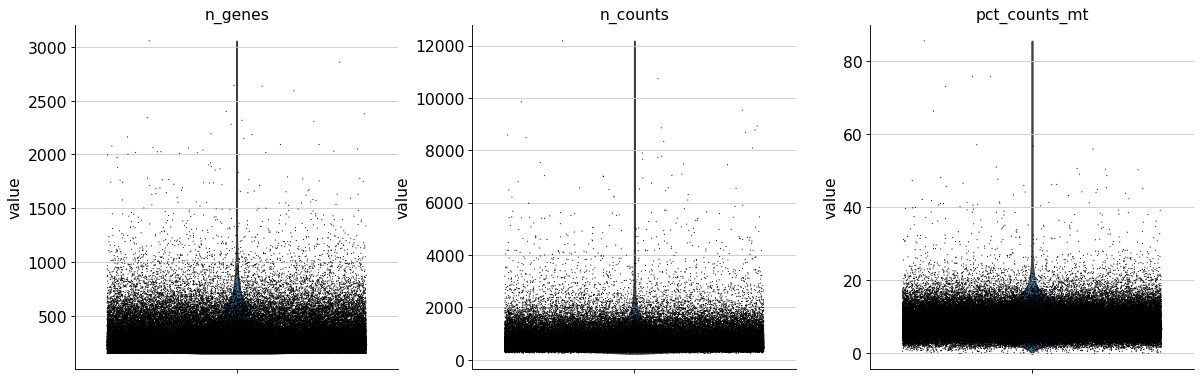

In [18]:
sc.pl.violin(data, ['n_genes', 'n_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

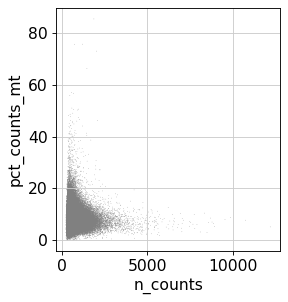

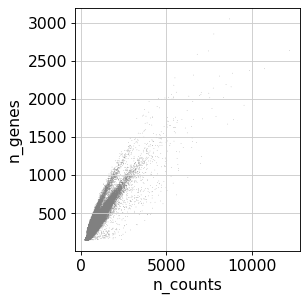

In [20]:
sc.pl.scatter(data, x='n_counts', y='pct_counts_mt')
sc.pl.scatter(data, x='n_counts', y='n_genes')

/mnt/scratch/geiramh/miniconda3/envs/scanpy-1.7.0/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/mnt/scratch/geiramh/miniconda3/envs/scanpy-1.7.0/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/mnt/scratch/geiramh/miniconda3/envs/scanpy-1.7.0/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


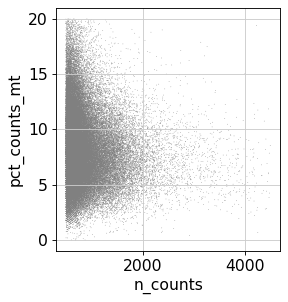

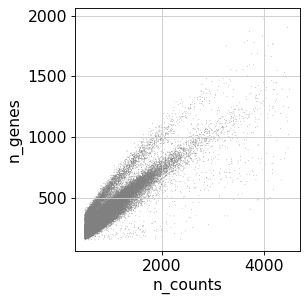

In [21]:
data = data[data.obs['pct_counts_mt'] < 15,:]
data = data[data.obs['n_counts'] > 3e3,:]
data = data[data.obs['n_counts'] < 25e3,:]
sc.pl.scatter(data, x='n_counts', y='pct_counts_mt')
sc.pl.scatter(data, x='n_counts', y='n_genes')

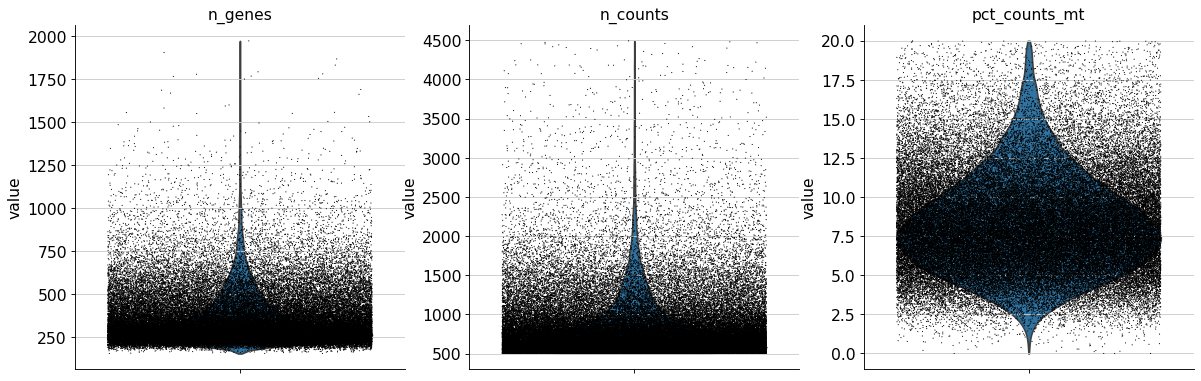

In [22]:
sc.pl.violin(data, ['n_genes', 'n_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, save="_post_filter.pdf")

In [23]:
data.obs["n_counts"].mean()

861.453

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
/mnt/scratch/geiramh/miniconda3/envs/scanpy-1.7.0/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing counts per cell
    finished (0:00:00)


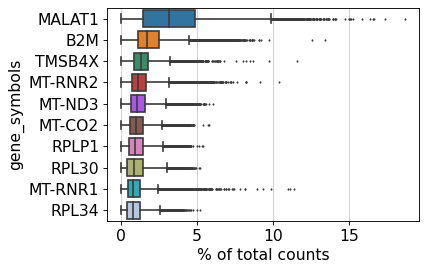

In [25]:
sc.pp.normalize_per_cell(data, counts_per_cell_after=1e6)
sc.pl.highest_expr_genes(data, n_top=10, gene_symbols='gene_symbols')

In [27]:
sc.pp.log1p(data)

In [35]:
sc.pp.highly_variable_genes(data, n_top_genes=3000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


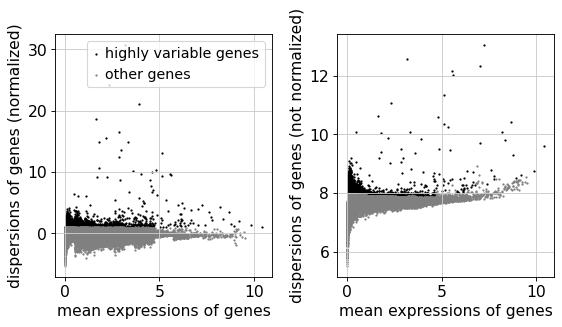

In [37]:
sc.pl.highly_variable_genes(data, save=".pdf")

In [39]:

data = data[:, data.var['highly_variable']]

/mnt/scratch/geiramh/miniconda3/envs/scanpy-1.7.0/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [40]:
sc.tl.pca(data)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


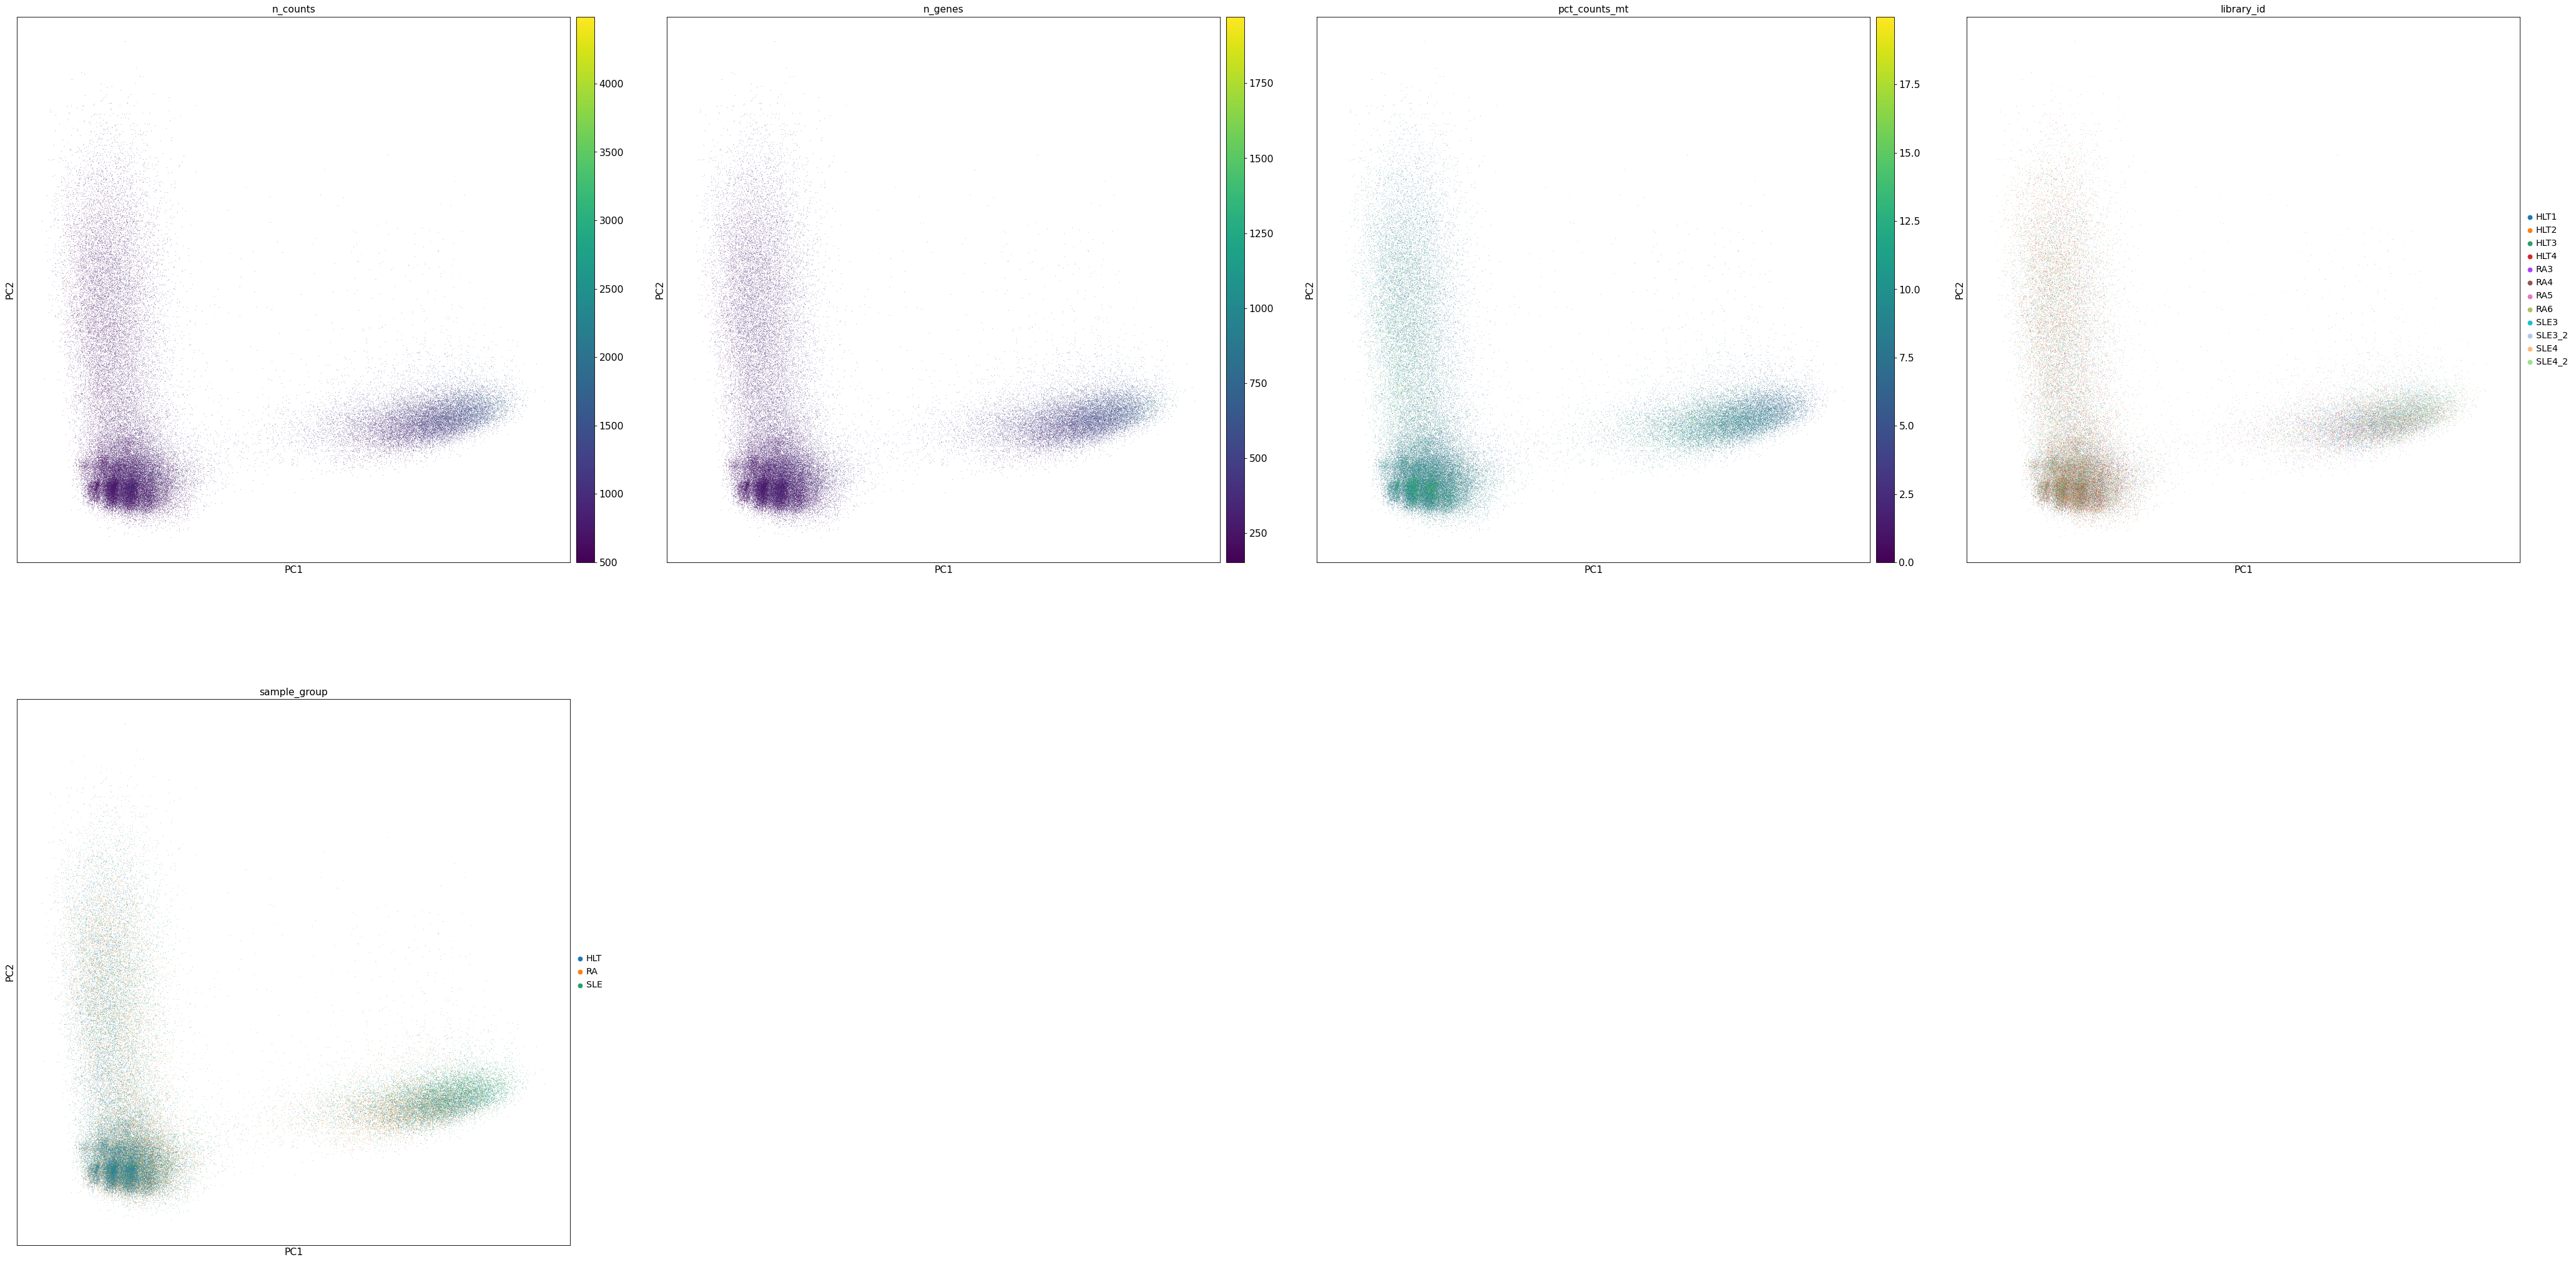

In [80]:
sc.pl.pca_scatter(data, color=['n_counts', 'n_genes','pct_counts_mt', 'library_id'])

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:33)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:31)


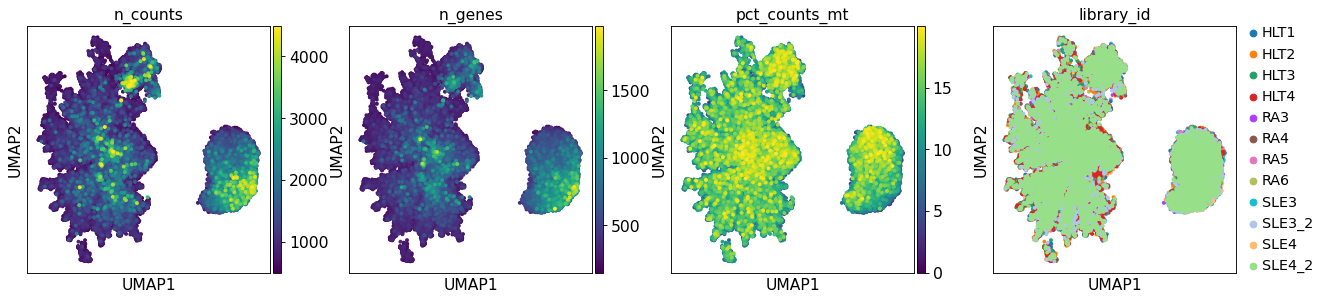

In [42]:
sc.pp.neighbors(data)
sc.tl.louvain(data)
sc.tl.umap(data)

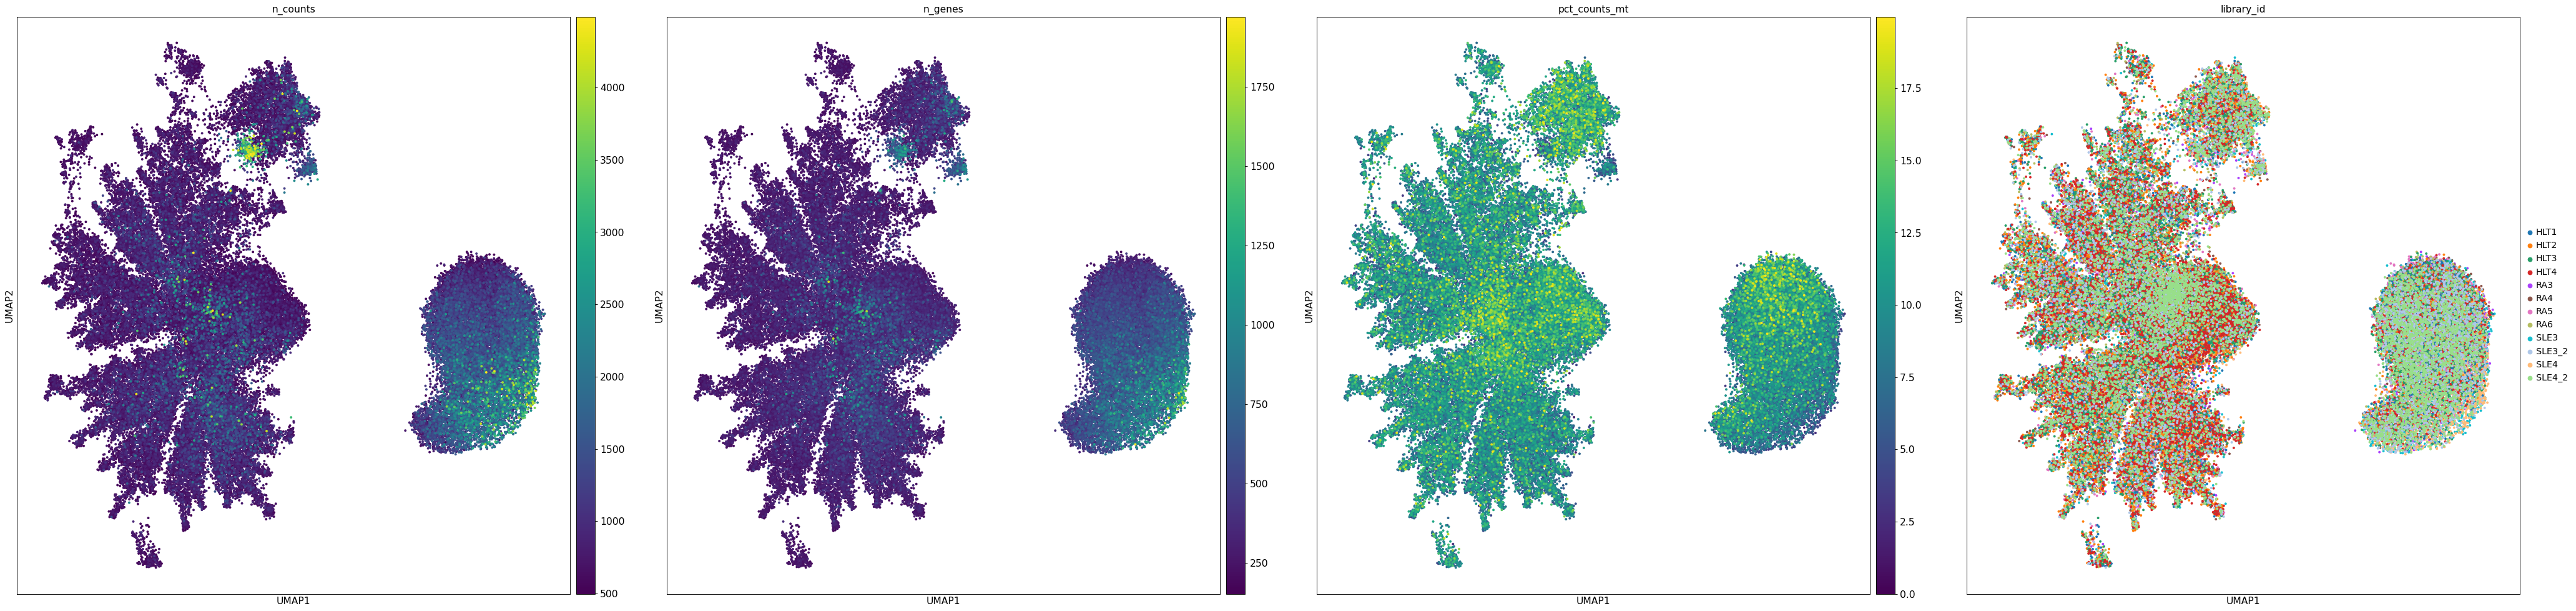

In [79]:
sc.pl.umap(data, color=['n_counts', 'n_genes','pct_counts_mt','library_id'], s=50)

In [ ]:
with open(snakemake.output[0],'w+') as of:
    of.write("done")
